<a href="https://colab.research.google.com/github/aaron-sandoval/vision-transformers/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

## Remote Imports

In [1]:
import os
import sys
from pathlib import Path

In [2]:
!pip install kiwi_mlutils
import kiwi_mlutils
# from kiwi_mlutils.train import training, engine

In [3]:
from kiwi_mlutils import retrieval
from kiwi_mlutils.train.training import accuracy_fn
from kiwi_mlutils.misc import set_seeds
from kiwi_mlutils.train import engine
from kiwi_mlutils import plotting

In [4]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [55]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np
import einops
from einops.layers.torch import Rearrange, Reduce
from PIL import Image

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    import torchinfo
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    import torchinfo


## Local File Imports

In [6]:
if False:
  from google.colab import drive

  print('Mounting Google Drive...')
  gdrive = "G"
  drive.mount(gdrive)
  project_path = Path(gdrive)/"My Drive"/"Academics"/"Replication_ViT" # @param: str
  if project_path not in sys.path:
      sys.path.append(str(project_path))
  !ls "$project_path"

In [7]:
# import mlutils.misc
# import mlutils.plotting
# import mlutils.retrieval
# from mlutils.train import training, engine

## Hardware Setup

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Data

## Load Data

In [9]:
# Download pizza, steak, sushi images from GitHub
image_path = kiwi_mlutils.retrieval.download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [10]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## DataLoaders

### Create Transforms

In [11]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### Create `DataLoader`s

In [12]:
BATCH_SIZE = 32

In [13]:
# Create data loaders
train_dataloader, test_dataloader, class_names = kiwi_mlutils.retrieval.create_image_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78d90f3b80a0>,
 ['pizza', 'steak', 'sushi'])

In [14]:
batch, labels = next(iter(train_dataloader))
image, label = batch[0], labels[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

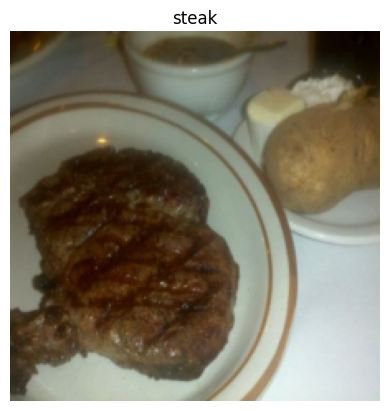

In [15]:
# rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

# Model Architecture

ViT paper Table 3
\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 . C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}

## Embeddings



### Patch Embeddings

First we can pick some hyperparameters and directly calculate the number of patches

In [16]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P
hidden_size = 768  # D

# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)  # N
flattened_image_shape = number_of_patches, patch_size**2 * color_channels  # x_p \in N x P^2C
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")
print(f"{flattened_image_shape=}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196
flattened_image_shape=(196, 768)


#### Manual Patch Creation

Try visualizing turning the test image into patches

(-0.5, 223.5, 15.5, -0.5)

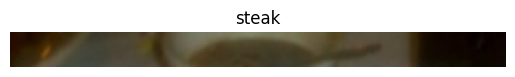

In [17]:
image_permuted = image.permute(1,2,0)
patch_top_row = image_permuted[:patch_size,:,:]
plt.imshow(patch_top_row)
plt.title(class_names[label])
plt.axis(False)


(14, 14)


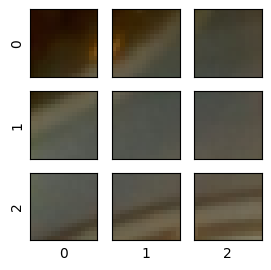

In [18]:
assert height % patch_size == 0 and width % patch_size == 0
patch_grid_shape = height//patch_size, width//patch_size
print(f"{patch_grid_shape}")
plot_shape = (3,3)

# Create a series of subplots
fig, axs = plt.subplots(nrows=plot_shape[0],
                        ncols=plot_shape[1], # one column for each patch
                        figsize=plot_shape,
                        sharex=True,
                        sharey=True)

for i, j in np.ndindex(plot_shape):
  axs[i, j].imshow(image_permuted[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :])
  axs[i, j].set_xlabel(j) # set the label
  axs[i, j].set_ylabel(i) # set the label
  axs[i, j].set_xticks([])
  axs[i, j].set_yticks([])
  axs[i, j].label_outer()

#### Patch Embeddings via CNN

By setting the `kernel_size` and `stride` parameters of a `torch.nn.Conv2d()` layer equal to the patch_size, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch.

In [19]:
image_projection = nn.Conv2d(color_channels, flattened_image_shape[1], kernel_size=patch_size, stride=patch_size, padding=0)

In [20]:
# Pass the image through the convolutional layer
image_out_of_conv = image_projection(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Let's look at a few random feature maps created by the Conv2D

Showing random convolutional feature maps from indexes: [391, 531, 186, 496, 426]


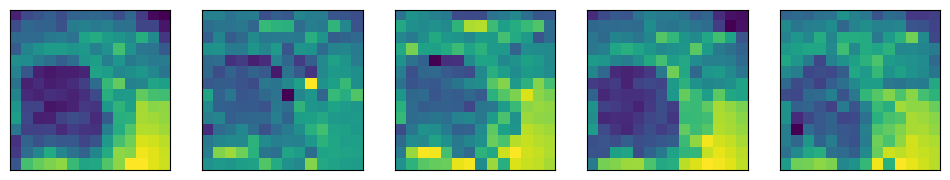

In [21]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

Now flatten and permute it to match the $N \times (P^2C)=(196,768)$ in the paper. Keep the leading unit dimension since that's the batch

In [22]:
projection_flatten = nn.Flatten(2, -1)
flattened = einops.rearrange(image_out_of_conv, "batch hidden h w -> batch (h w) hidden")
# flattened = projection_flatten(image_out_of_conv)
# print(f"{flattened.shape}")
flattened.shape

torch.Size([1, 196, 768])

We can't do everything in a single `rearrange` since that can't add a linear layer with a select number of hidden channels.

#### Compose the above into a Patch Embedding PyTorch module

In [23]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int = 3, patch_size: int = 16, embedding_dim: int = 768):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    super().__init__()
    self.patcher = nn.Conv2d(in_channels, embedding_dim, patch_size, patch_size, padding=0)
    self.flattener = Rearrange("batch hidden_channel h w -> batch (h w) hidden_channel")


  def forward(self, x):
    assert x.shape[-1] % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {x.shape[-1]}, patch size: {patch_size}"
    # return einops.rearrange(self.patcher(x), "batch hidden_channel h w -> batch (h w) hidden_channel")
    return self.flattener(self.patcher(x))

Try it out

In [24]:
set_seeds()
patchify = PatchEmbedding()
patched = patchify(image.unsqueeze(0))
patched.shape

torch.Size([1, 196, 768])

In [25]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
torchinfo.summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Rearrange (flattener)                  [1, 768, 14, 14]     [1, 196, 768]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### Class Token Embedding

In [26]:

# View the patch embedding and patch embedding shape
print(f"Patch embedding shape: {patched.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [27]:
batch_size, _, embedding_dimension = patched.shape

# A (1, embedding_dim) class token for each image
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [28]:
patch_embedded_image_with_class_embedding = torch.cat([class_token, patched], dim=1)
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

### Position Embedding

In [29]:
position_embedding = nn.Parameter(torch.ones(patch_embedded_image_with_class_embedding.shape), requires_grad=True)
full_embedding = patch_embedded_image_with_class_embedding + position_embedding

In [30]:
set_seeds()
color_channels, height, width = image.shape
# height = 224 # H ("The training resolution is 224.")
# width = 224 # W
# color_channels = 3 # C
patch_size = 16 # P
hidden_size = 768  # D

# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)  # N

image_batch = einops.rearrange(image, "c h w -> 1 c h w")
patch_embedding_layer = PatchEmbedding()
patch_embeddings = patch_embedding_layer(image_batch)
patch_embedded_image_with_class_embedding = torch.cat([class_token, patched], dim=1)
position_embedding = nn.Parameter(torch.ones(patch_embedded_image_with_class_embedding.shape), requires_grad=True)
full_embedding = patch_embedded_image_with_class_embedding + position_embedding
full_embedding.shape


torch.Size([1, 197, 768])

## Multi-Headded Attention
We'll create our own MSA block to include
- Self-attention layer
- LayerNorm
- Residual
This will make it easier to copy this substructure later on

In [31]:
class MultiheadSelfAttentionBlock(nn.Module):
  """
  Includes MSA and LayerNorm, no residual
  """
  def __init__(self, embed_size=12, num_heads=12, dropout: float = 0.0, batch_first: bool = True):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embed_size)
    self.msa: nn.MultiheadAttention = nn.MultiheadAttention(embed_size, num_heads, dropout=dropout, batch_first=batch_first)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_out, _ = self.msa(query=x, key=x, value=x, need_weights=False)
    return attn_out

In [32]:
msa = MultiheadSelfAttentionBlock(embedding_dimension, num_heads=12)
msa_out = msa(full_embedding)
msa_out.shape

torch.Size([1, 197, 768])

## MLP

In [33]:
class MLPBlock(nn.Module):
  def __init__(self, d_resid: int = 768, d_mlp: int = 3072, dropout: float = 0.1):
    super().__init__()
    dropout_layer = nn.Dropout(dropout) if dropout > 1e-6 else nn.Identity()
    self.layers = nn.Sequential(
        nn.LayerNorm(d_resid),
        nn.Linear(d_resid, d_mlp),
        nn.GELU(),
        dropout_layer,
        nn.Linear(d_mlp, d_resid),
        dropout_layer,
    )

  def forward(self, x):
    return self.layers(x)

In [34]:
mlp_block = MLPBlock()
mlp_block(msa_out).shape

torch.Size([1, 197, 768])

## Transformer Encoder

In [35]:
class TransformerEncoderBlock(nn.Module):
  def __init__(
      self,
      d_resid: int = 768,
      num_heads: int = 12,
      mlp_size: int = 3072, # MLP size from Table 1 for ViT-Base
      mlp_dropout: float = 0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
      attn_dropout: float = 0
  ):
    super().__init__()
    self.msa = MultiheadSelfAttentionBlock(
        embed_size=d_resid,
        num_heads=num_heads,
        dropout=attn_dropout,
    )
    self.mlp = MLPBlock(
        d_resid=d_resid,
        d_mlp=mlp_size,
        dropout=mlp_dropout
    )

  def forward(self, x):
    x = x + self.msa(x)
    return x + self.mlp(x)

In [36]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
torchinfo.summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa)                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (msa)                    --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    └─Sequential (layers)                         [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─LayerNorm (0)                          [1, 197, 768]        [1, 197, 768]        1,536                True
│    │    └─Linear (1)                     

Create the same encoder as above with torch.nn.TransformerEncoderLayer()

In [37]:

torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [38]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
torchinfo.summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Vision Transformer Top Level

In [39]:
class ViT(nn.Module):
  def __init__(
      self,
      image_size = 224, # H, W
      color_channels = 3, # C
      patch_size = 16, # P
      num_classes: int = 1000,
      num_transformer_layers: int = 12,
      d_resid: int = 768,
      num_heads: int = 12,
      mlp_size: int = 3072, # MLP size from Table 1 for ViT-Base
      mlp_dropout: float = 0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
      attn_dropout: float = 0.0,
      embedding_dropout: float = 0.1
  ):
    super().__init__()
    # Patch, position, class embeddings
    assert image_size % patch_size == 0
    num_patches = (image_size // patch_size)**2
    self.patch_embedding = PatchEmbedding(in_channels=color_channels, patch_size=patch_size, embedding_dim=d_resid)
    self.class_embedding = nn.Parameter(torch.randn(1, 1, d_resid), requires_grad=True)
    self.position_embedding = nn.Parameter(torch.randn(1, num_patches+1, d_resid), requires_grad=True)
    self.embedding_dropout = nn.Dropout(embedding_dropout)

    # Transformer encoder
    self.layers = nn.Sequential(*[TransformerEncoderBlock(d_resid=d_resid, num_heads=num_heads, mlp_size=mlp_size, mlp_dropout=mlp_dropout, attn_dropout=attn_dropout) for _ in range(num_transformer_layers)])

    # Classifier
    self.classifier = nn.Sequential(
        nn.LayerNorm(d_resid),
        nn.Linear(in_features=d_resid, out_features=num_classes)
    )

  def forward(self, x):
    # Embedding
    x = self.patch_embedding(x)
    class_embedding_batched = einops.repeat(self.class_embedding, "1 seq d_resid -> batch seq d_resid", batch = x.shape[0])
    x = torch.cat([class_embedding_batched, x], dim=1)
    x += self.position_embedding
    x = self.embedding_dropout(x)

    # Transformer encoder
    x = self.layers(x)

    # Classifier
    return self.classifier(x[...,0,:])


In [40]:
vit = ViT()
# preds = vit(batch)

In [ ]:
# preds.shape

In [41]:

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
torchinfo.summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [32, 3, 224, 224]    [32, 1000]           152,064              True
├─PatchEmbedding (patch_embedding)                 [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                            [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Rearrange (flattener)                       [32, 768, 14, 14]    [32, 196, 768]       --                   --
├─Dropout (embedding_dropout)                      [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (layers)                              [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                 [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─MultiheadSelfAttentionBlock (msa)  

# Training

In [ ]:
optimizer = torch.optim.Adam(vit.parameters(), lr=3e-3, weight_decay=0.3)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, )
loss_fn = nn.CrossEntropyLoss()

In [ ]:
set_seeds()
# train_results = engine.train(
#     vit,
#     train_dataloader,
#     test_dataloader,
#     optimizer,
#     loss_fn,
#     epochs=2,
#     device=device,
# )

## Training Results

In [ ]:
# kiwimlutils.plotting.plot_loss_curves(train_results)

# Pretrained Model Transfer Learning

## Load Model

In [42]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 54.0MB/s]


Replace the model head to fine tune on our dataset

In [43]:

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [44]:
# Print a summary using torchinfo (uncomment for actual output)
torchinfo.summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

## Dataloaders

In [45]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [46]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [47]:
# Create data loaders
train_dataloader, test_dataloader, class_names = kiwi_mlutils.retrieval.create_image_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,
    batch_size=BATCH_SIZE
)

## Training

In [48]:
optimizer = torch.optim.Adam(pretrained_vit.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, )
loss_fn = nn.CrossEntropyLoss()

In [49]:
set_seeds()
train_results = engine.train(
    pretrained_vit,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_fn,
    epochs=2,
    device=device,
)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977


## Plot Results

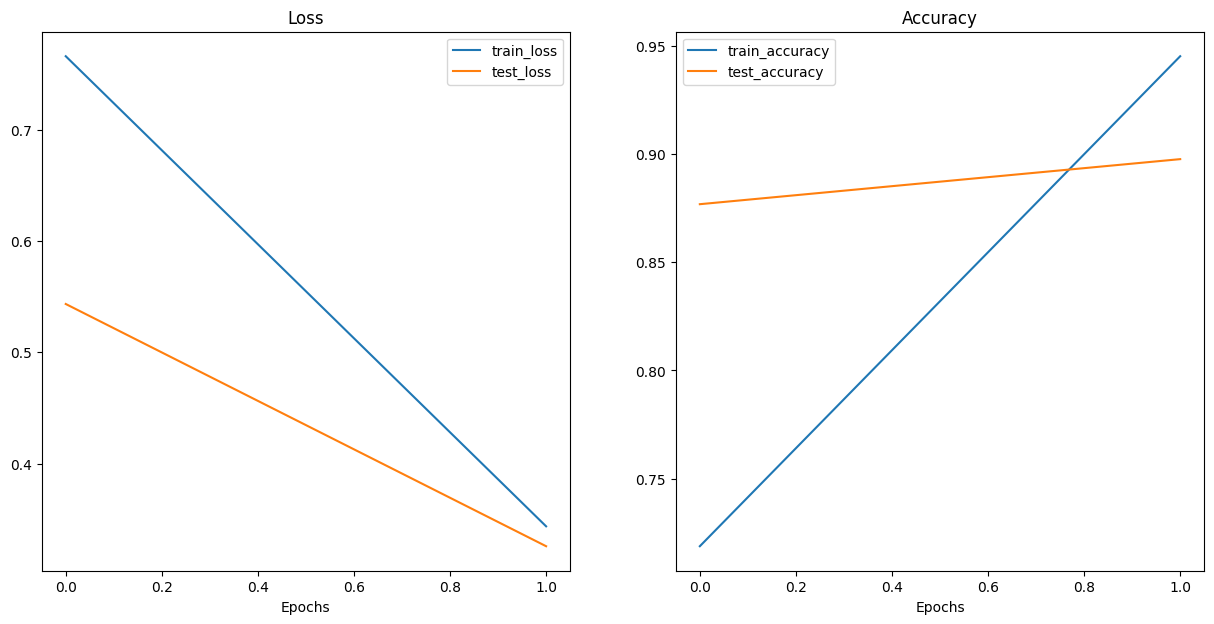

In [53]:
plotting.plot_loss_curves(train_results)

# Predict on Custom Image

In [54]:
import requests

# Import function to make predictions on images and plot them
# from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")


In [56]:
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: list[str],
    image_path: str,
    image_size: tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)

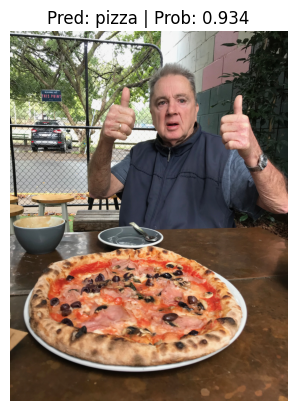

In [57]:

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)